## Análise de estilo dinâmica utilizando Filtro de Kalman - Quebra estrutural

Seguindo o notebook anterior, inclui uma descontinuidade no portfolio, onde a posição em um ativo é zerada no mesmo momento que outro ativo, que não estava antes no portfólio é comprado.

### Importação de bibiliotecas e definições padrão

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import string

from filterpy.common import Saver
from filterpy.kalman import rts_smoother
from filterpy.kalman import KalmanFilter, EnsembleKalmanFilter

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)

### Ativos 
São definidos 3 ativos (a,b,c) com retornos $r$ aleatóriamente distribuidos da seguinte forma:

$$
\begin{align}
\begin{pmatrix}
r_a\\
r_b\\
r_c
\end{pmatrix}
& \sim 
\mathcal{N}
\begin{pmatrix}
\mu , 
\Sigma
\end{pmatrix};
\end{align}
\Sigma = \sigma \cdot \sigma^T \cdot \rho
$$
com :
$$
\begin{align}
\mu = 
\begin{pmatrix}
0\\
0\\
0
\end{pmatrix};
\sigma = 
\begin{pmatrix}
0.4\\
0.15\\
0.05
\end{pmatrix} * \dfrac{1}{\sqrt{252}};
\rho = 
\begin{pmatrix}
1 & 0.7 & 0\\
0.7 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\end{align}
$$
<br>
a amostra dos retornos de cada ativo são 1000 dias comerciais desde 01/01/2000

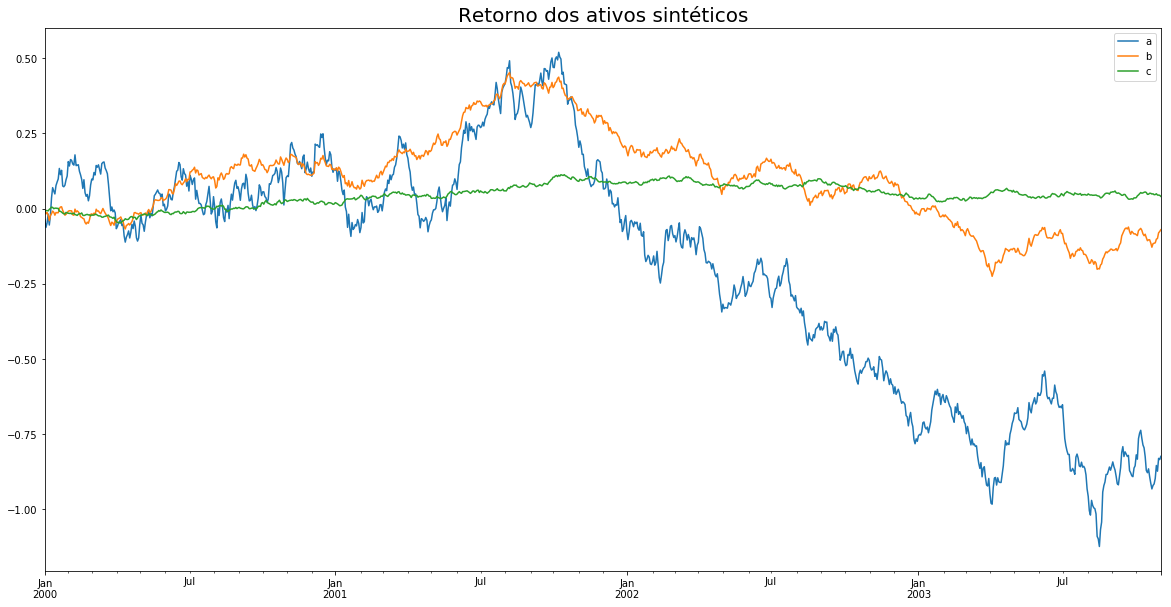

In [136]:
mean = [0, 0, 0]
stds = np.array([0.4, 0.15, 0.05]) / 252 ** 0.5
corr = np.eye(3) 
corr[1,0] = corr[0,1]  = 0.7
cov = np.multiply(np.outer(stds,stds), corr)
returns = np.random.multivariate_normal(mean, cov, 1000)
stock = pd.DataFrame(returns, columns=list(string.ascii_lowercase[:len(mean)]), index=pd.date_range('2000-01-01', freq='B', periods=returns.shape[0]))
stock.cumsum().plot(figsize=(20,10))
plt.title("Retorno dos ativos sintéticos", fontsize='20');

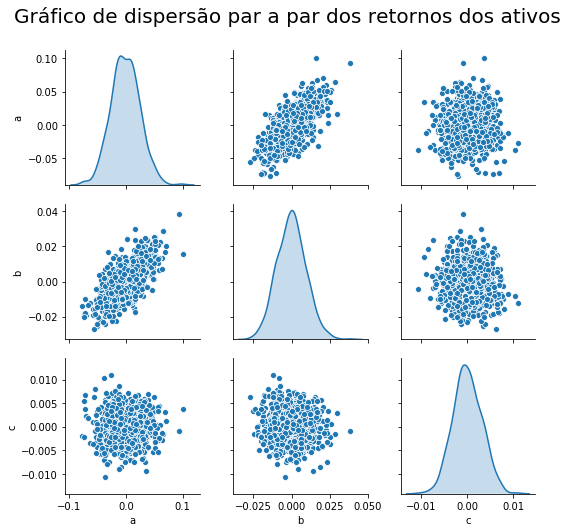

In [137]:
g = sns.pairplot(stock, diag_kind='kde')
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Gráfico de dispersão par a par dos retornos dos ativos", fontsize='20');

## Portfolio
Portfolio semelhante ao portfolio do notebook anterior. 3 ativos inicialmente com pesos 0.5, 0.2 e 0, com compras e vendas aleatórias e uma mudança de alocação de a para c em 25/04/2002. Não há restrições para que os ativos somem 1 (podem haver mais ativos no portfolio, não mapeados)

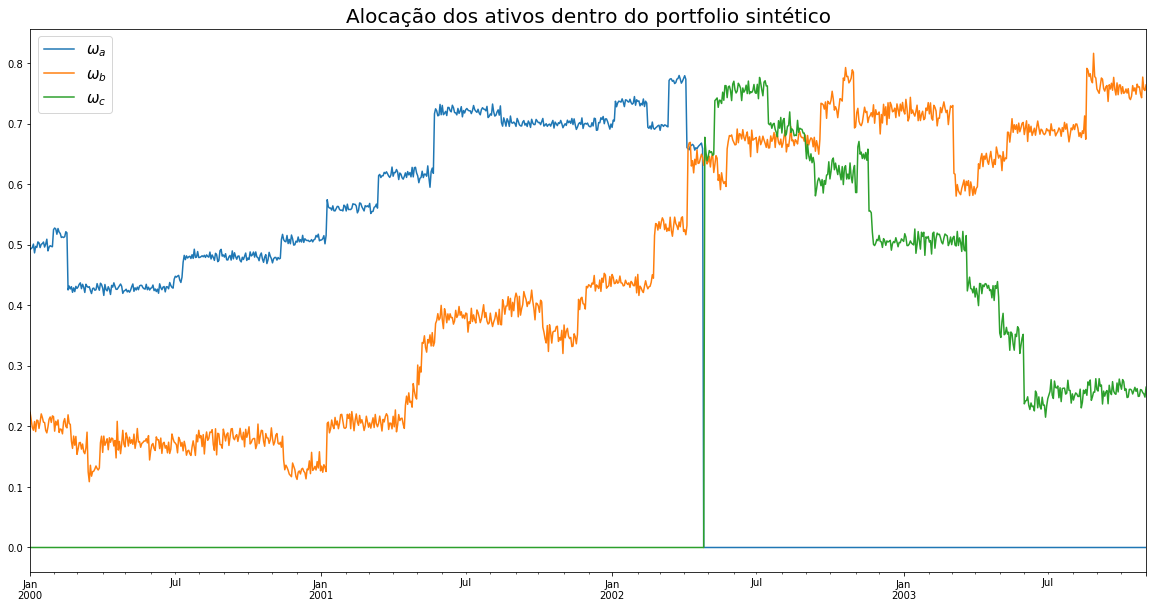

In [138]:
p1 = pd.DataFrame(index=stock.index, columns=stock.columns)
p1[['a','b','c']] = [0.5, 0.2, 0.3]


p1['a'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.02,1000)).cumsum()
p1['b'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.03,1000)).cumsum()
p1['c'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.05,1000)).cumsum()


p1['a'] += np.random.normal(0, 0.005, 1000) 
p1['b'] += np.random.normal(0, 0.01, 1000)
p1['c'] += np.random.normal(0, 0.01, 1000)

#realoca ção de a para c
p1.loc['2002-04-25':, 'a'] = 0
p1.loc[:'2002-04-25', 'c'] = 0

#p1 = p1.div(p1.sum(1), axis=0)

p1_return = p1.mul(stock).sum(1)

p1.plot(figsize=(20,10), legend=False)
plt.title("Alocação dos ativos dentro do portfolio sintético", fontsize='20');
plt.legend(['$\omega_a$','$\omega_b$','$\omega_c$'], fontsize='15');

####  Caso base

$ H = \begin{bmatrix} r_a & r_b & r_c  \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix}$ &nbsp; 
ou seja, não há nenhuma informação sobre o peso dos ativos disponíveis <br>

Adicionalmente o filtro é adaptativo, a cada iteração calcula-se o quadrado do erro residual normalizado, dado por: $ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$ e compara-se a um limiar $\epsilon_{limite} = 10 $ definido arbitrariamente. Enquanto  $ \epsilon > \epsilon_{limite} $ a Matriz Q, que representa a incerteza do processo, é multiplicada por 10, Assim que $ \epsilon < \epsilon_{limite} $ o valor de Q reduz-se gradualmente até o valor original

In [139]:
kf = KalmanFilter(3,4)

#State Transition Function F
kf.F = np.eye(3)

#Process Noise Q
kf.Q *= 1e-3

#Initial Guess (inicialização exata)
kf.x = p1.iloc[0].values
kf.P = np.array([0,0,0])

#Measurement Noise R
kf.R *= 1e-10

Q_scale_factor = 10
eps_max = 10

#faz o loop para cada data
s = Saver(kf)
epss = []
count = 0
for i,dt in enumerate(stock.index):
    #Measurement Function H
    kf.H = np.zeros((4,3))
    kf.H[0] = stock.loc[dt].values.reshape(1,3)
    kf.predict() 
    kf.update(np.hstack([p1_return.loc[dt], p1.loc[dt]]))
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    epss.append(eps)
    
    #quando o erro quadratico normalizado (eps) passa um determinado limite
    #a matriz Q é aumentada por um fator, permitindo uma maior variação do erro do processo
    if eps > eps_max:
        kf.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        kf.Q /= Q_scale_factor
        count -= 1
    s.save()  
s.to_array()

## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

#residuos ao quadrado normalizado
epss = pd.Series(np.array(epss), index=p1.index)

#organização dos dados para o plot
estimativas = pd.DataFrame(s.x, index=p1.index, columns=[r'$\hat{\omega_a}$',r'$\hat{\omega_b}$',r'$\hat{\omega_c}$' ])
estimativas_smooth = pd.DataFrame(sx, index=p1.index, columns=[r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_b}$ (smoothed)',r'$\hat{\omega_c}$ (smoothed)' ])
residuo_estimativa = pd.DataFrame(estimativas.values - p1.values, index=p1.index, columns=['residuo a', 'residuo b', 'residuo c'])
residuo_estimativa_smooth = pd.DataFrame(estimativas_smooth.values - p1.values, index=p1.index, columns=['residuo a (smooth)', 'residuo b (smooth)', 'residuo c (smooth)'])

incerteza = pd.DataFrame(s.P.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3
incerteza_smooth = pd.DataFrame(sP.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3

retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
residuo = (p1_return - retorno_estimado)

## Plota os Resultados da estimação

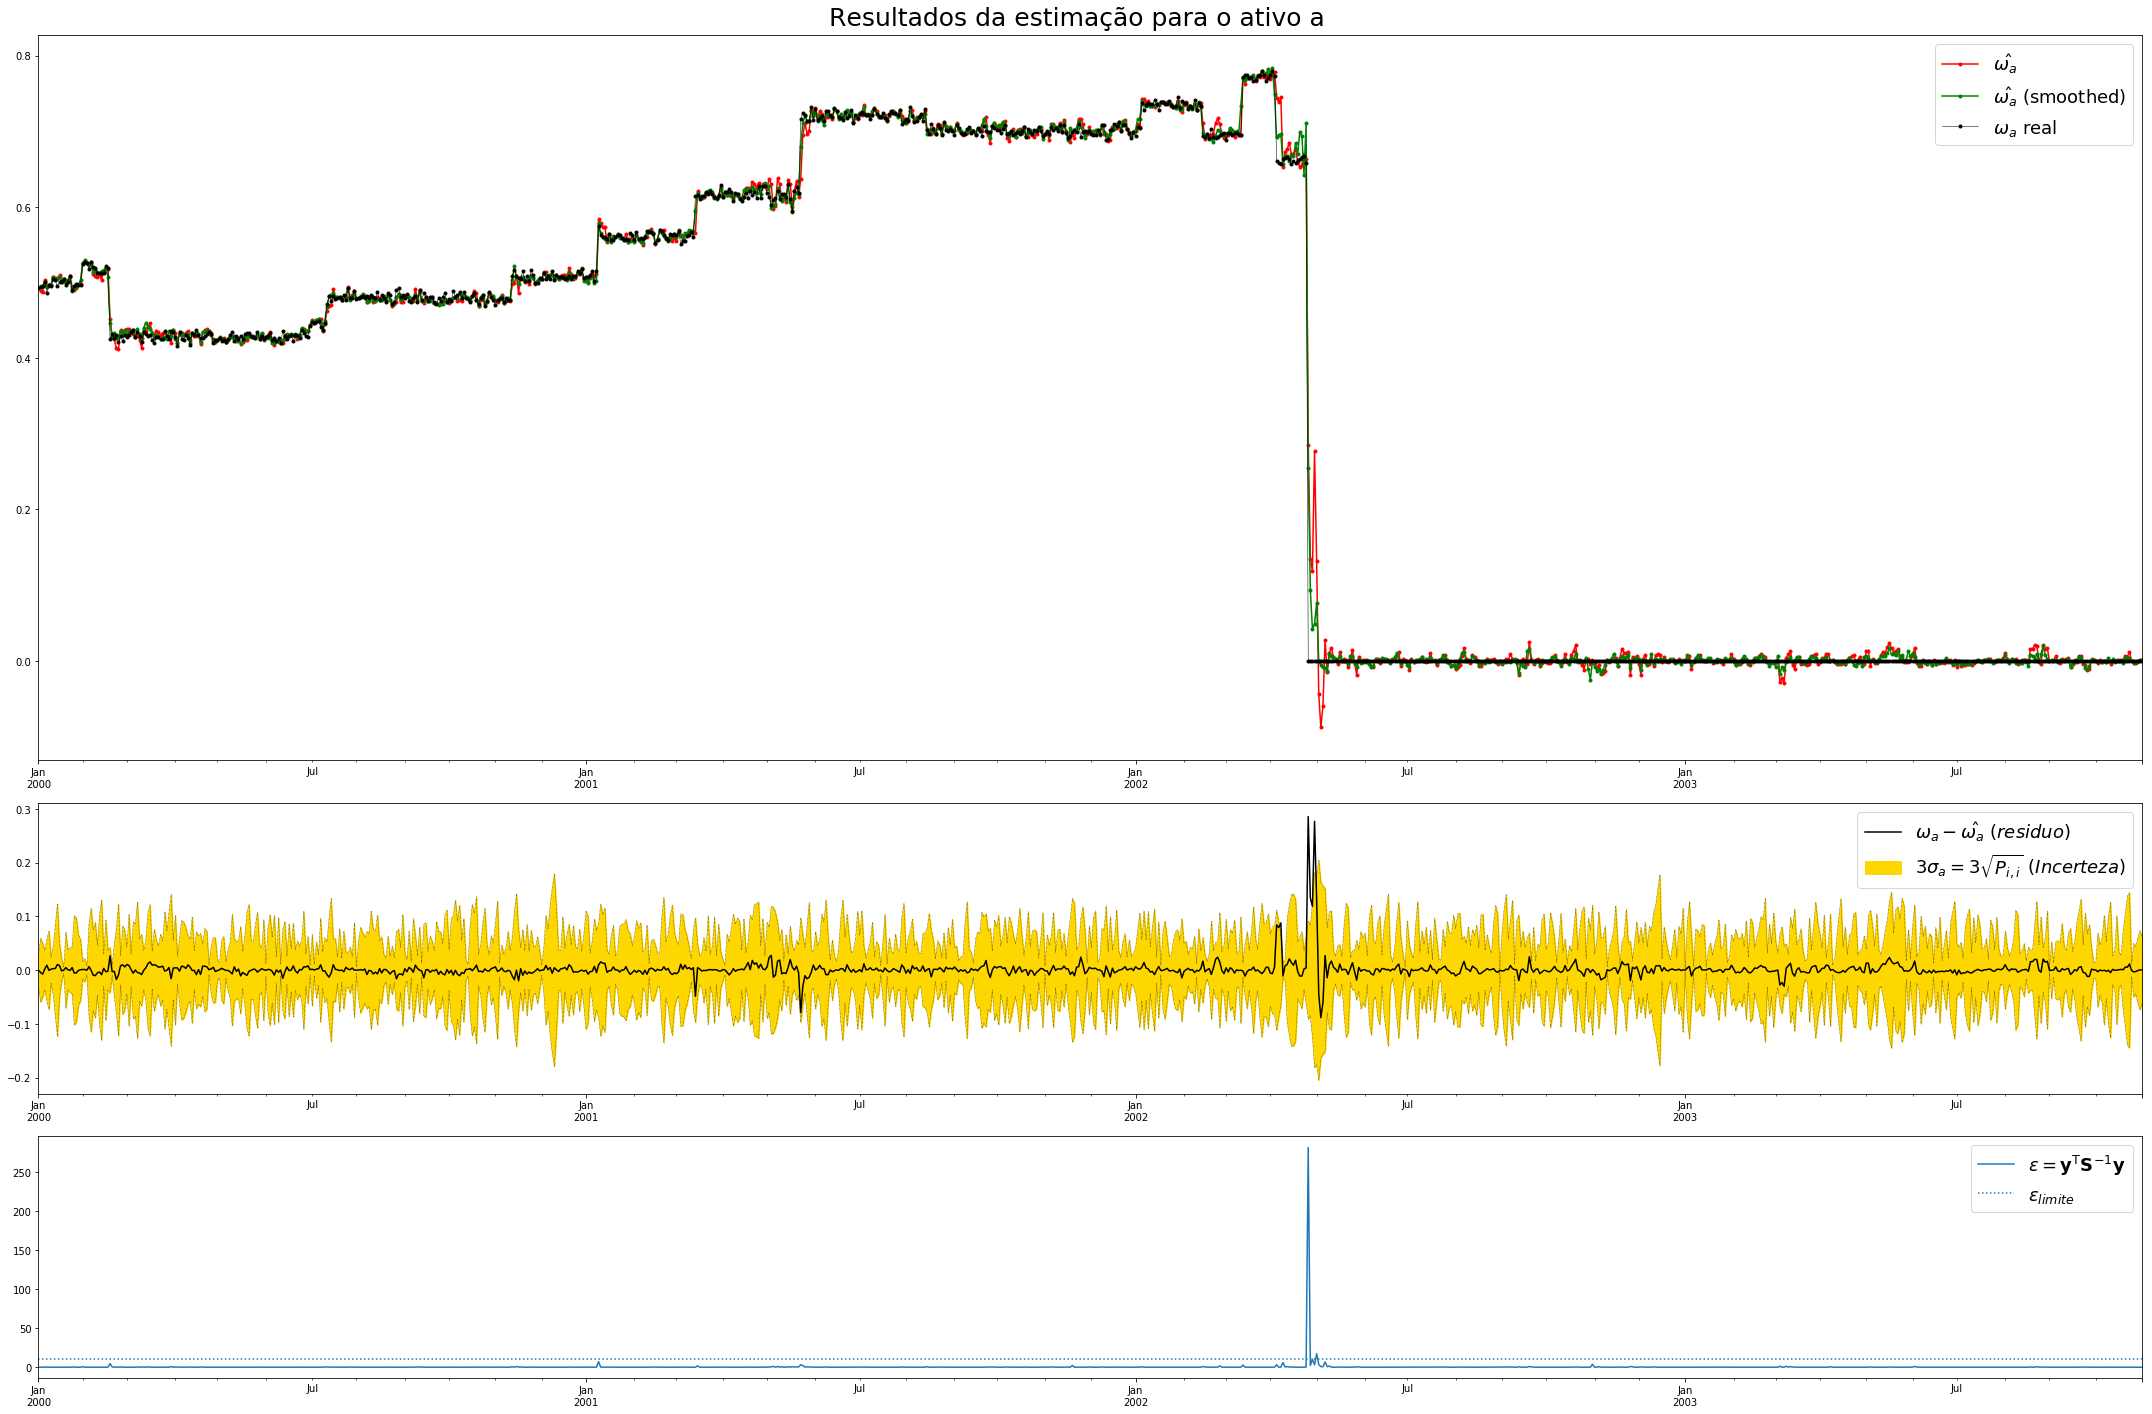

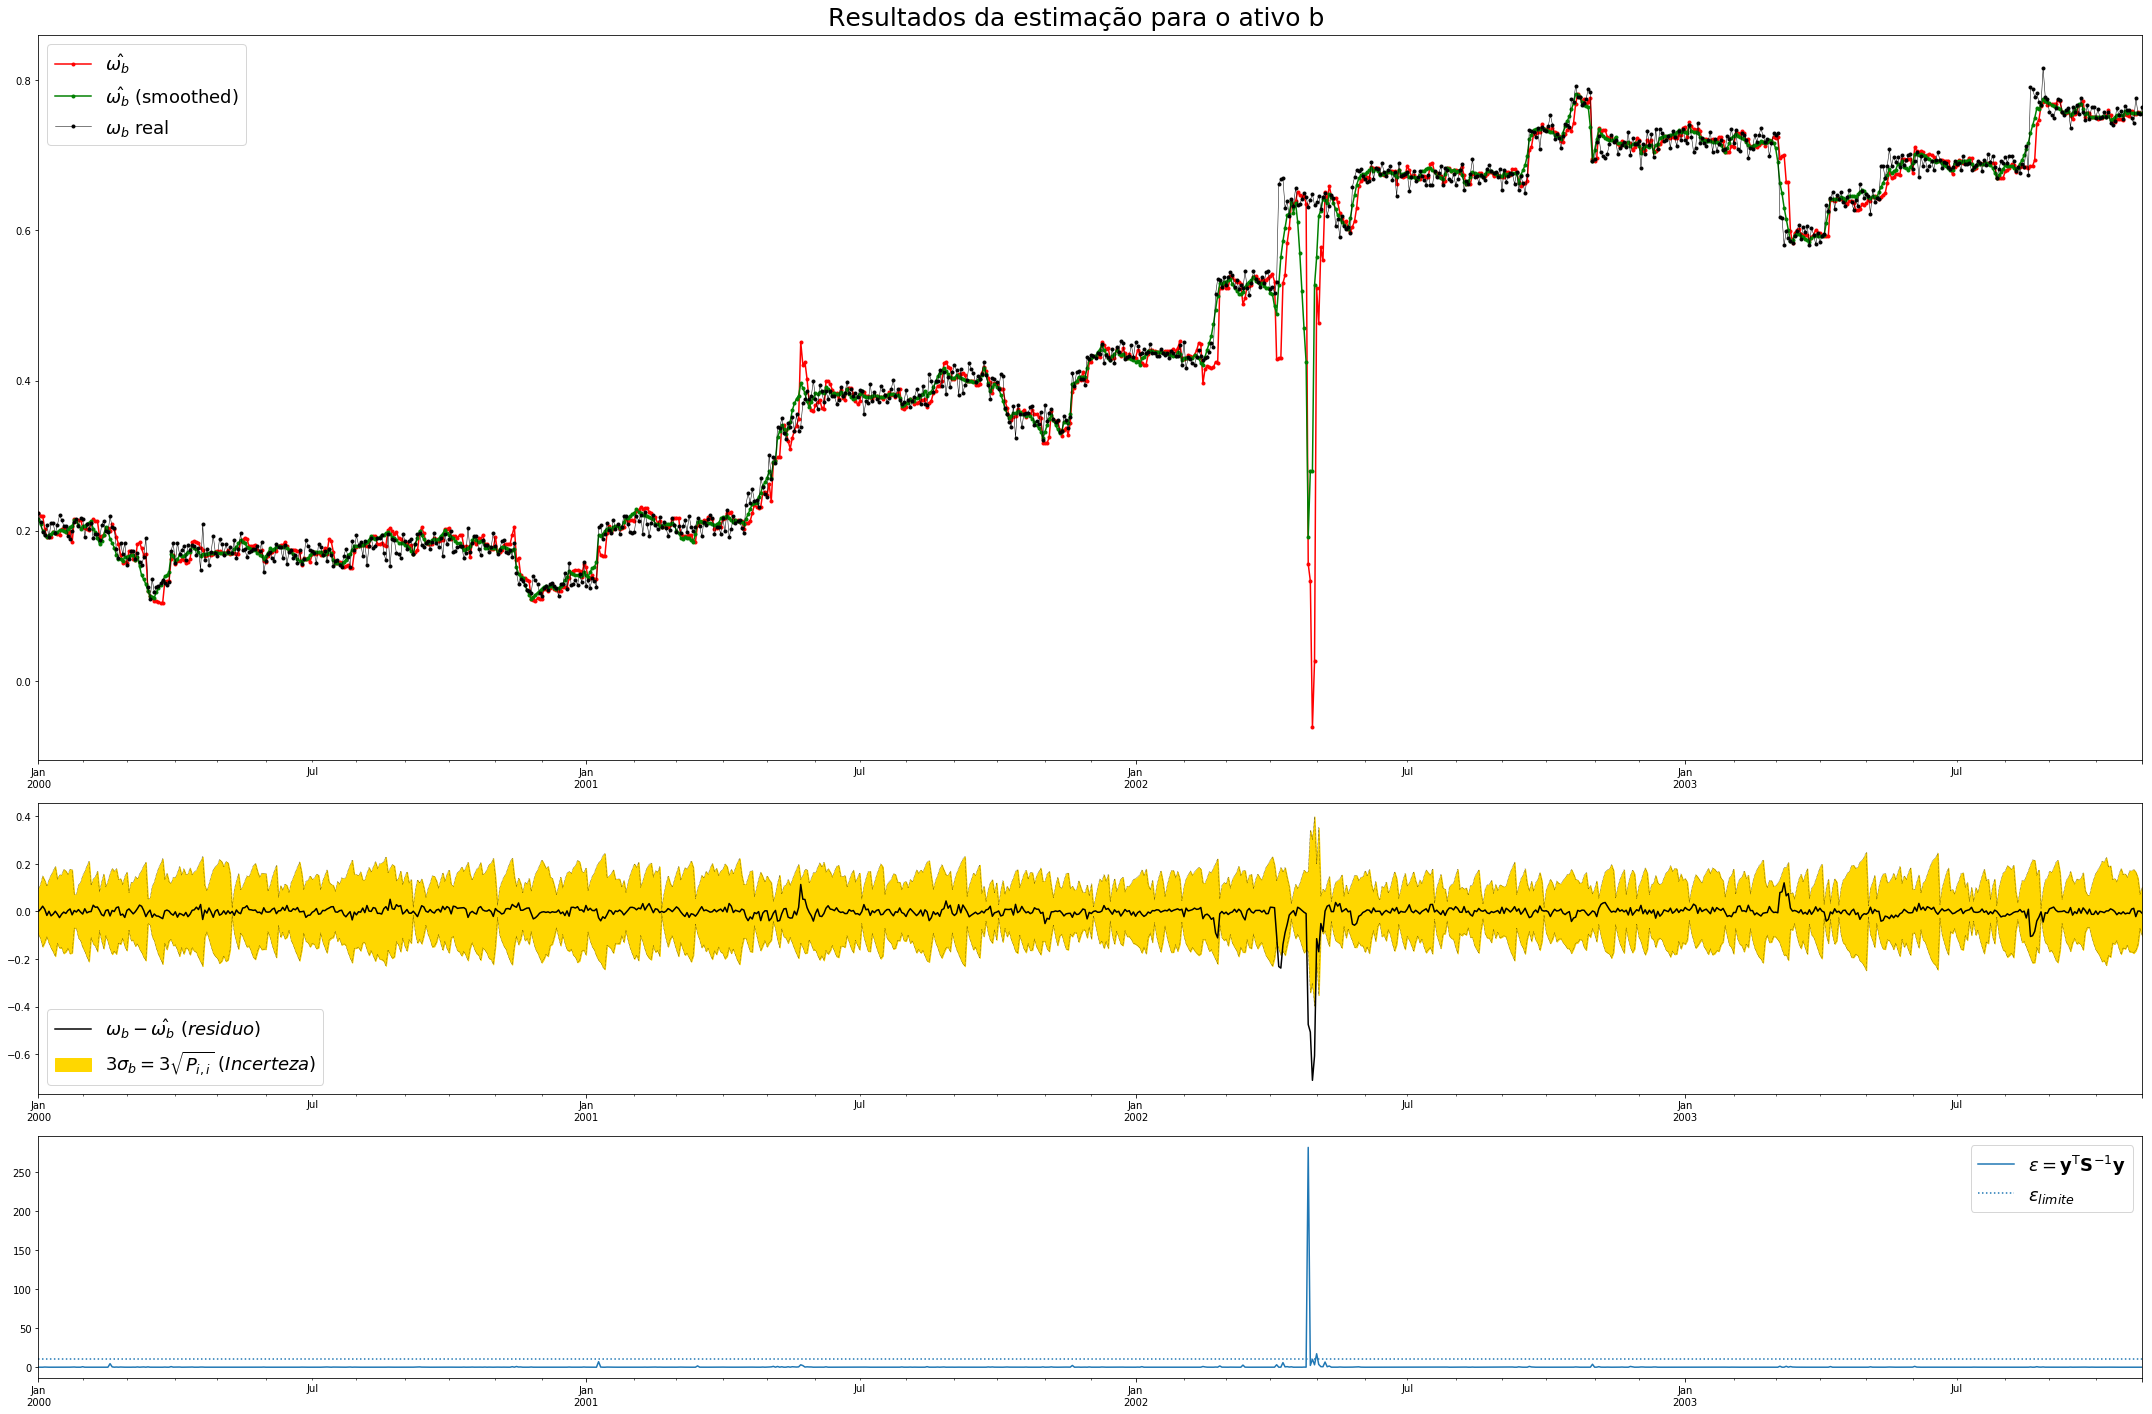

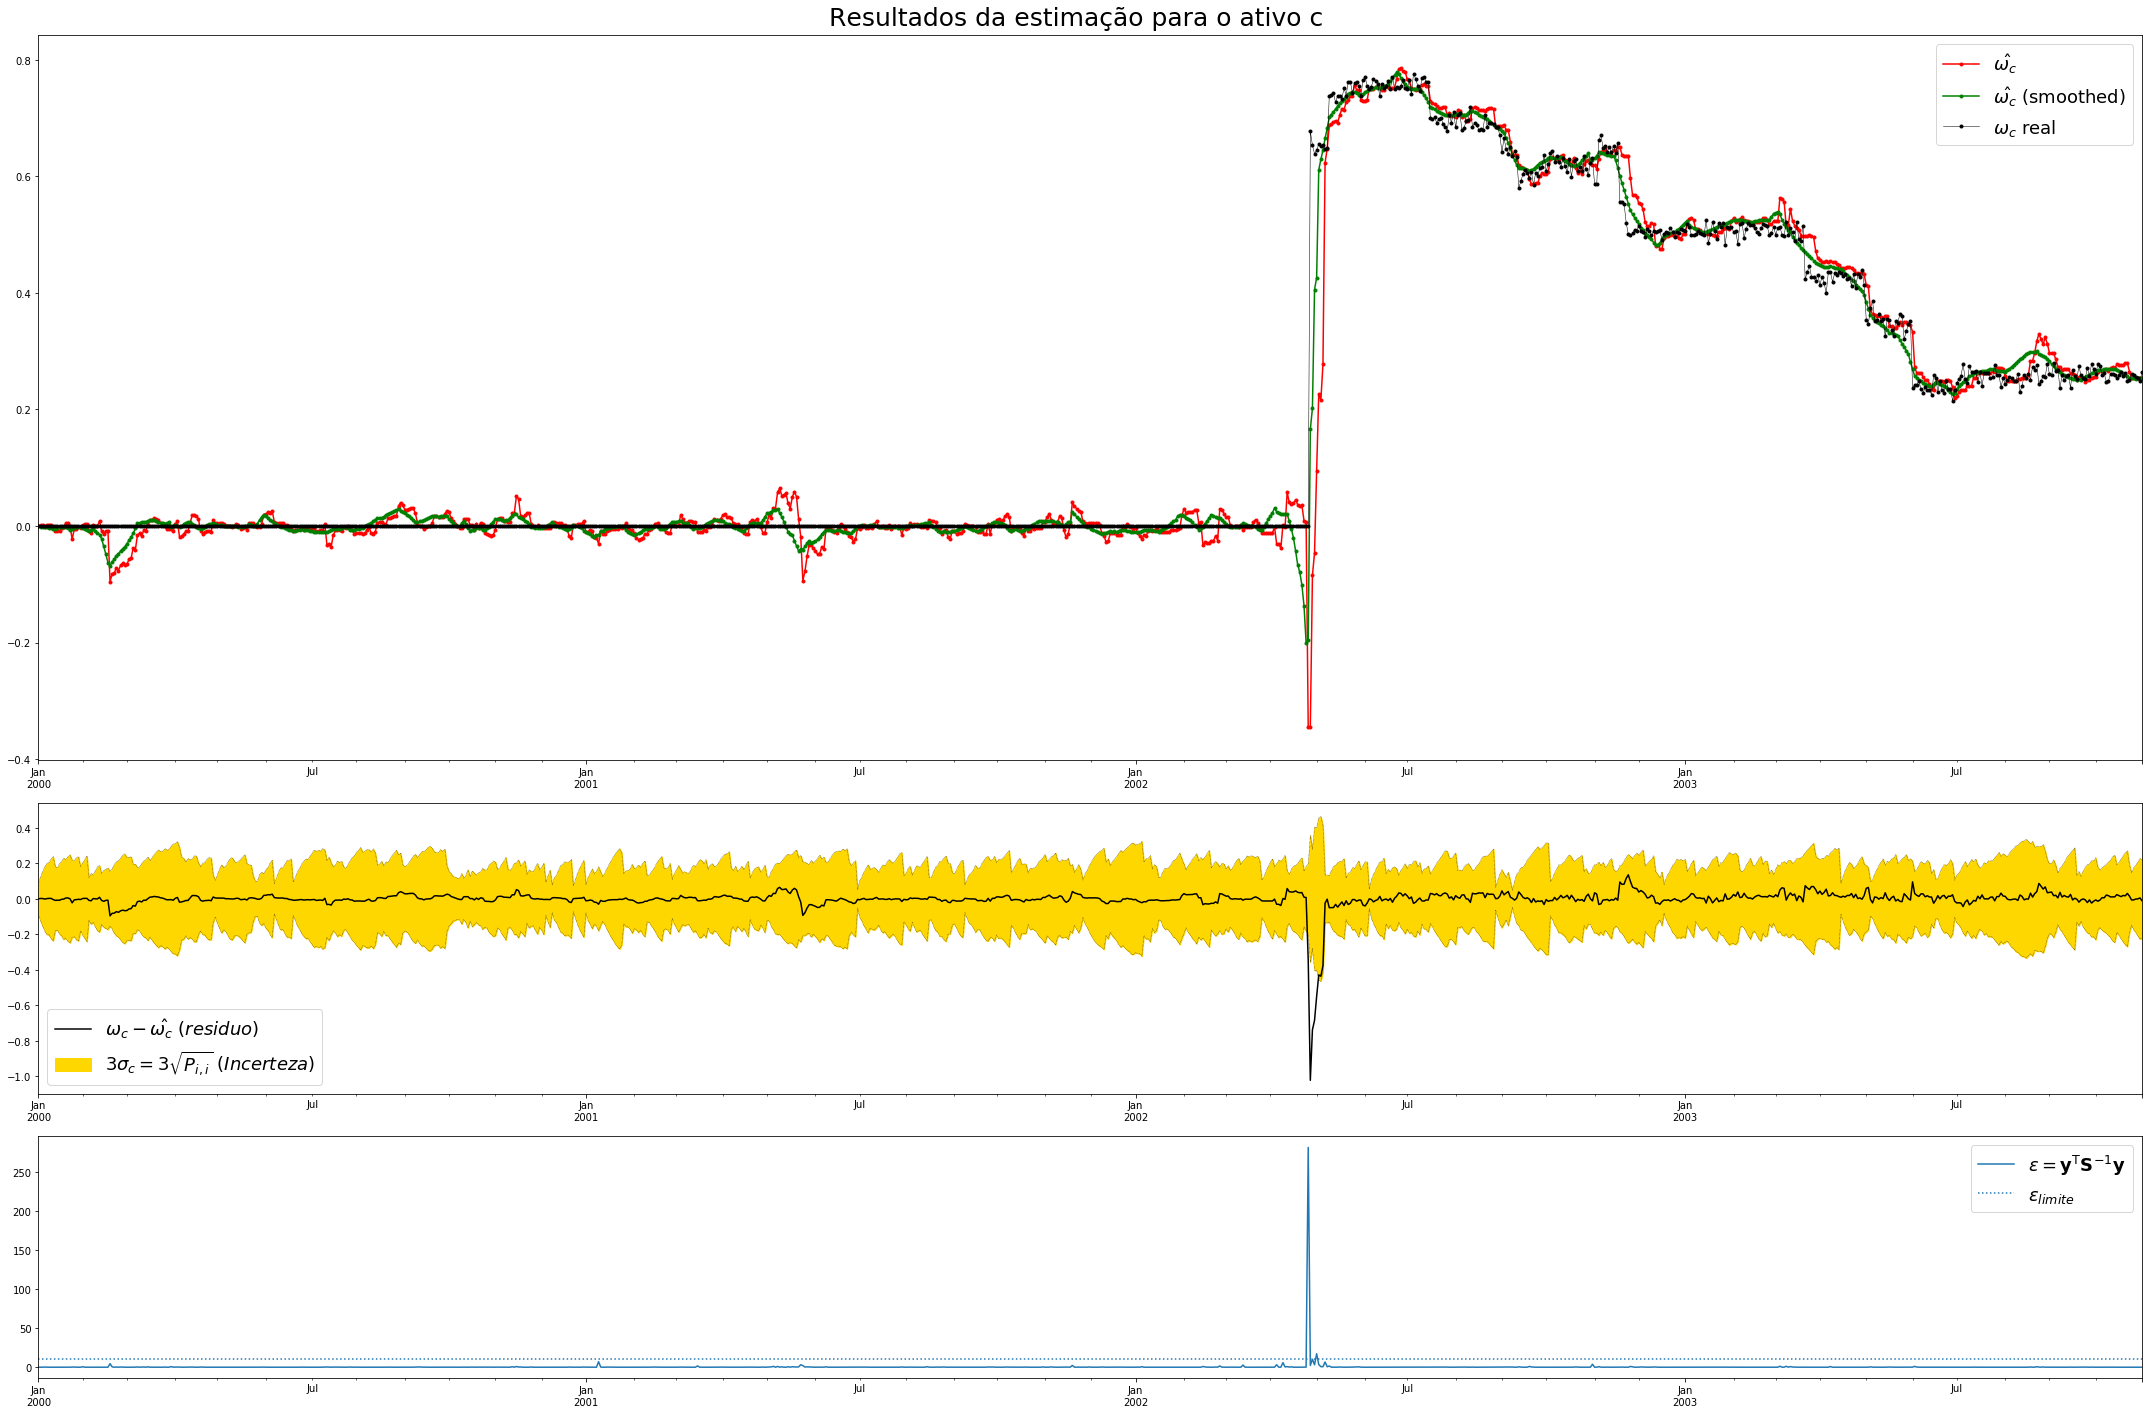

In [141]:
for i, c in enumerate(p1.columns):
    fig, (axu, axd, axd2) = plt.subplots(3,1, gridspec_kw=dict(height_ratios=[3,1.2,1]), figsize=(30,20))

    estimativas.iloc[:,i].plot(ax=axu, color='red', linestyle='-', lw=1.5, marker='.')
    estimativas_smooth.iloc[:,i].plot(ax=axu, color='green', linestyle='-', lw=1.5, marker='.')
    p1.iloc[:,i].plot(color='black', linestyle='-', lw=0.5, ax=axu, label=r'$\omega_{}$ real'.format(p1.columns[i]), marker='.')

    residuo_estimativa.iloc[:,i].plot(ax=axd, color='k', label='$\omega_{0} - \hat{{\omega_{0}}}\ (residuo)$'.format(p1.columns[i]))
    #residuo_estimativa_smooth.iloc[:,i].plot(ax=axd, color='green',ls='-')

    area = axd.fill_between(p1.index.to_native_types(), -incerteza.iloc[:,i]*1,incerteza.iloc[:,i]*1, color='gold')
    incerteza.iloc[:,i].mul(1).plot(ax=axd, ls=':', color='k', lw='.5')
    incerteza.iloc[:,i].mul(-1).plot(ax=axd, ls=':', color='k', lw='.5')

    #pd.DataFrame(s.y).iloc[:,0].plot(ax=axd2)
    epss.plot(label="$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$", ax=axd2)
    axd2.axhline(eps_max, ls=':', label="$\epsilon_{limite}$")

    axu.legend(fontsize=18)
    handlers, labels = axd.get_legend_handles_labels()
    axd.legend(handlers[:-2] + [area], labels[:-2] + ['$ 3\sigma_{} = 3\sqrt{{P_{{i,i}}}} \ (Incerteza)$'.format(p1.columns[i])], fontsize=18)

    axd2.legend(fontsize=18)

    fig.suptitle("Resultados da estimação para o ativo {}".format(p1.columns[i]), fontsize=25);
    plt.tight_layout(rect=[0,0,1,0.97])